# Sistema de recomendación de libros

El objetivo de esta libreta es construir un sistema de recomendación de libros basado en filtrado colaborativo. Para lograr esto se construirá un modelo de factor latente (LFM, por sus siglas en inglés) y la tećnica de optimización que se usará es el descenso del gradiente estocástico.

Los pasos a realizar en la construcción del sistema de recomendación son:

1. Análisis de los datos
2. Construcción de la matriz de ratings
3. Inicializar la matriz de factores
4. Calcular el error usando el error cuadrático medio
5. Minimizar el error usando el descenso del gradiente
6. Generación de las recomendaciones

### 1. Análisis de los datos

In [1]:
"""Carga de bibliotecas"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""Carga de la base de datos de libros"""
books = pd.read_csv('../data/books/Books.csv', sep=',', error_bad_lines=False, encoding="latin-1")

print("Tamaño de la bd de libros: ", books.shape)
print("Número de libros únicos: ",(books.bookISBN.unique().size))

books.head() #damos un vistazo a los datos

Tamaño de la bd de libros:  (3000, 8)
Número de libros únicos:  3000


,Unnamed: 0,Unnamed: 0.1,bookISBN,bookName,author,yearOfPublication,publisher,urlId
0,62044,26575,1551669382,Enchanted Afternoon,Susan Wiggs,2002,Mira,120656.0
1,85751,1995,0743202961,Every Breath You Take : A True Story of Obsess...,Ann Rule,2001,Free Press,116803.0
2,122688,7677,067151699X,The HIDDEN LIFE OF DOGS,Elizabeth Marshall Thomas,1995,Pocket,1805.0
3,87360,36120,0804108528,Inadmissible Evidence,Philip Friedman,1993,Ivy Books,139375.0
4,73712,30238,0061094145,"The Fifth Dominion (Imajica, Book 1)",Clive Barker,1995,HarperTorch,141585.0


In [3]:
#selección de variables de interés
df_books = books[['bookISBN','bookName','author','yearOfPublication','publisher']]
df_books

,bookISBN,bookName,author,yearOfPublication,publisher
0,1551669382,Enchanted Afternoon,Susan Wiggs,2002,Mira
1,0743202961,Every Breath You Take : A True Story of Obsess...,Ann Rule,2001,Free Press
2,067151699X,The HIDDEN LIFE OF DOGS,Elizabeth Marshall Thomas,1995,Pocket
3,0804108528,Inadmissible Evidence,Philip Friedman,1993,Ivy Books
4,0061094145,"The Fifth Dominion (Imajica, Book 1)",Clive Barker,1995,HarperTorch
...,...,...,...,...,...
2995,0842314296,Hinds' Feet on High Places,Hannah Hurnard,1997,Living Books
2996,0380774933,Keeper of the Heart,Johanna Lindsey,1993,Avon
2997,0451459407,"Death Masks (The Dresden Files, Book 5)",Jim Butcher,2003,Roc
2998,0064440028,Danny and the Dinosaur,Syd Hoff,1992,HarperTrophy


In [29]:
"""Carga de la base de datos de usuarios"""
users = pd.read_csv('../data/books/Users.csv', sep=',', error_bad_lines=False, encoding="latin-1")

print("Tamaño de la bd de usuarios: ", users.shape)
print("Número de usuarios únicos: ",(users.user.unique().size))

users.head() #damos un vistazo a los datos

Tamaño de la bd de usuarios:  (1000, 5)
Número de usuarios únicos:  1000


,Unnamed: 0,Unnamed: 0.1,user,location,age
0,57300,43156,43157.0,"windsor, ontario, canada",22.0
1,40638,99031,99032.0,"white plains, new york, usa",25.0
2,54265,42882,42883.0,"the woodlands, texas, usa",51.0
3,83797,183799,183800.0,"quebec, quebec, canada",29.0
4,96743,188795,188796.0,"toronto, ontario, canada",NaN


In [5]:
#selección de variables de interés
df_users = users[['user','location', 'age']]
df_users

,user,location,age
0,43157.0,"windsor, ontario, canada",22.0
1,99032.0,"white plains, new york, usa",25.0
2,42883.0,"the woodlands, texas, usa",51.0
3,183800.0,"quebec, quebec, canada",29.0
4,188796.0,"toronto, ontario, canada",NaN
...,...,...,...
995,277195.0,"san francisco, california, usa",54.0
996,259035.0,NaN,38.0
997,13221.0,"iqaluit, nunavut, canada",45.0
998,207616.0,"choctaw, oklahoma,",53.0


In [6]:
"""Carga de la base de datos de transacciones"""
ratings = pd.read_csv('../data/books/UserEvents.csv', sep=',', error_bad_lines=False, encoding="latin-1")

print("Tamaño de la bd de transacciones: ", ratings.shape)
print("Número de libros únicos: ",(ratings.user.unique().size))
print("Número de usuarios únicos: ",(ratings.bookId.unique().size))

ratings.head() #damos un vistazo a los datos

Tamaño de la bd de transacciones:  (141081, 4)
Número de libros únicos:  13030
Número de usuarios únicos:  11234


,Unnamed: 0,user,bookId,impression
0,16,276747,0060517794,checkout
1,19,276747,0671537458,checkout
2,20,276747,0679776818,add to cart
3,133,276822,0060096195,checkout
4,137,276822,0375821813,checkout


In [7]:
#selección de variables de interés
df_ratings= ratings[['user','bookId', 'impression']]
df_ratings

,user,bookId,impression
0,276747,0060517794,checkout
1,276747,0671537458,checkout
2,276747,0679776818,add to cart
3,276822,0060096195,checkout
4,276822,0375821813,checkout
...,...,...,...
141076,276688,0836218655,checkout
141077,276688,0836236688,checkout
141078,276688,1551669315,interact
141079,276704,0345386108,interact


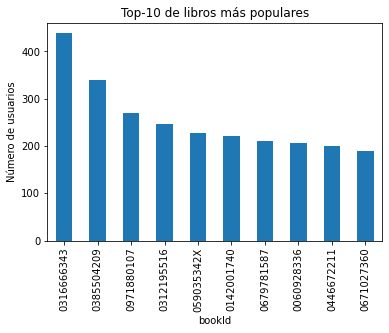

In [8]:
cpdel = df_ratings['bookId'].value_counts()[:10].plot(kind='bar',title='Top-10 de libros más populares') #'1'= mujer, '2'= hombre
plt.xlabel('bookId')
plt.ylabel('Número de usuarios')
plt.show()

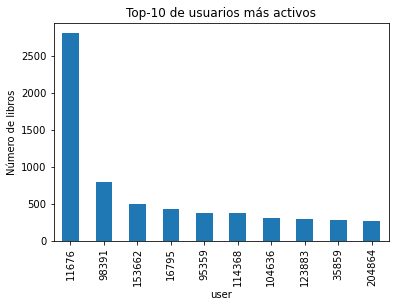

In [9]:
cpdel = df_ratings['user'].value_counts()[:10].plot(kind='bar',title='Top-10 de usuarios más activos') #'1'= mujer, '2'= hombre
plt.xlabel('user')
plt.ylabel('Número de libros')
plt.show()

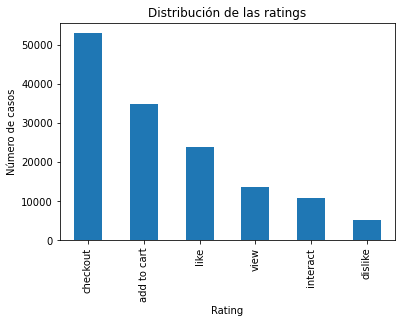

In [10]:
cpdel = df_ratings['impression'].value_counts()[:10].plot(kind='bar',title='Distribución de las ratings')
plt.xlabel('Rating')
plt.ylabel('Número de casos')
plt.show()

In [11]:
"""Convertir los ratings a un valor numérico: no le gustó= 1,...,pago=6"""
df_ratings["impression"] = ratings["impression"].map({"dislike":1,"view":2,"interact":3,
                                                     "like":4, "add to cart":5, "checkout":6})
df_ratings

,user,bookId,impression
0,276747,0060517794,6
1,276747,0671537458,6
2,276747,0679776818,5
3,276822,0060096195,6
4,276822,0375821813,6
...,...,...,...
141076,276688,0836218655,6
141077,276688,0836236688,6
141078,276688,1551669315,3
141079,276704,0345386108,3


In [12]:
"""Promediar el rating"""
avg_rating = pd.DataFrame(df_ratings.groupby('bookId')['impression'].mean()) #generamos df agrupando por libro y rating
avg_rating['ConteoRating'] = pd.DataFrame(ratings.groupby('bookId')['impression'].count()) #añadimos columna "ratingCount"
avg_rating.sort_values('ConteoRating', ascending=False).head(10) #ordenar el top-10

,impression,ConteoRating
bookId,,
0316666343,5.061644,438
0385504209,5.227139,339
0971880107,1.996296,270
0312195516,5.077236,246
059035342X,5.511013,227
0142001740,5.176471,221
0679781587,5.223810,210
0060928336,4.801932,207
0446672211,5.000000,200


### 2. Construcción de la matriz de ratings

In [13]:
"""Usando la función pivote, creamos la matriz R"""

ratings_pivote = df_ratings.pivot(index='user',columns = 'bookId',values='impression').fillna(0)
print("Tamaño de la matriz R: ",ratings_pivote.shape)
ratings_pivote.head(15)

Tamaño de la matriz R:  (13030, 11234)


bookId,0002005018,0002251760,0002259001,0003300277,0006374921,0006480764,000648302X,0006485014,0006485200,0006493580,...,950491036X,9580464162,9722015184,9722020609,9726101794,9726106141,9726116902,9727722458,9770390107900,9871138148
user,,,,,,,,,,,,,,,,,,,,,
8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#visualizamos como la matriz R
ratings_pivote.values

array([[2., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
"""Extracción de usuarios y libros para representarlos como listas (y las reservamos) """
user_lista = list(ratings_pivote.index)
book_lista = list(ratings_pivote.columns)

In [16]:
from scipy.sparse import coo_matrix

"""Construir una matriz dispersa"""
R = coo_matrix(ratings_pivote.values)
print ("Tamaño de la matriz R", R.shape)

Tamaño de la matriz R (13030, 11234)


### 3. Inicializar la matriz de factores

In [17]:
"""Inicializar las matrices U y V"""
M, N = R.shape
print("Tamaño de las matrices M y N: ", M,N)
K = 3 #no. de factores a calcular

U=np.random.rand(M,K) #inicializar la matriz U
V=np.random.rand(K,N) #inicalizar la matriz V

print("Tamaño de la matriz U: ", U.shape)
print(U)
print("Tamaño de la matriz V: ", V.shape)
print(V)

Tamaño de las matrices M y N:  13030 11234
Tamaño de la matriz U:  (13030, 3)
[[0.01645195 0.25842073 0.6667486 ]
 [0.7529737  0.94384378 0.78325104]
 [0.42794561 0.47101828 0.9068196 ]
 ...
 [0.47139215 0.28394198 0.52113103]
 [0.18557554 0.08609715 0.45713188]
 [0.75483735 0.01199777 0.19205242]]
Tamaño de la matriz V:  (3, 11234)
[[0.01681638 0.29690588 0.27536043 ... 0.20088038 0.01192567 0.09086713]
 [0.47650498 0.62820039 0.42744162 ... 0.61021095 0.26024272 0.94494028]
 [0.80039919 0.31745729 0.12416671 ... 0.05740575 0.12526319 0.90665109]]


### 4. Calcular el error usando el error cuadrático medio

In [18]:
"""Función para calcular el error cuadrático"""
from numpy.linalg import norm

def error(R,U,V,lamda=0.02):
    ratings = R.data
    filas = R.row
    columnas = R.col
    e = 0 
    for ui in range(len(ratings)):
        rui=ratings[ui]
        u = filas[ui]
        i = columnas[ui]
        if rui>0:
            e= e + pow(rui-np.dot(U[u,:],V[:,i]),2)+\
                lamda*(pow(norm(U[u,:]),2)+pow(norm(V[:,i]),2))
    return e

In [19]:
#Calcular el error
rmse = np.sqrt(error(R,U,V)/len(R.data))
print("RMSE: ", rmse)

RMSE:  4.1506302111771705


### 5. Minimizar el error usando el descenso del gradiente

In [20]:
"""Función para optimizar las matrices U y V usando el SGD"""

def SGD(R, K, lamda=0.02,steps=10, gamma=0.001):
    M,N = R.shape
    U = np.random.rand(M,K)
    V = np.random.rand(K,N)
    
    rmse = np.sqrt(error(R,U,V,lamda)/len(R.data))
    print("RMSE inicial: "+str(rmse))
    
    for step in range(steps):
        for ui in range(len(R.data)):
            rui=R.data[ui]
            u = R.row[ui]
            i = R.col[ui]
            if rui>0:
                eui=rui-np.dot(U[u,:],V[:,i])
                U[u,:]=U[u,:]+gamma*2*(eui*V[:,i]-lamda*U[u,:])
                V[:,i]=V[:,i]+gamma*2*(eui*U[u,:]-lamda*V[:,i])
        rmse = np.sqrt(error(R,U,V,lamda)/len(R.data))
        if rmse<0.5:
            break
    print("RMSE final: "+str(rmse))
    return U,V

In [21]:
U,V=SGD(R,K=3,gamma=0.0007,lamda=0.001, steps=500)

RMSE inicial: 4.160137831556753
RMSE final: 0.8708177034142457


In [22]:
#Generar las predicciones para todos los usuarios
pred_user_ratings =np.matmul(U, V)
pred_user_ratings

array([[1.95848325, 2.36393138, 2.80090149, ..., 1.73135439, 2.33959625,
        2.61713928],
       [4.96162527, 5.04297331, 3.56942392, ..., 4.68061031, 0.27996053,
        5.53037801],
       [6.30785247, 7.26961456, 7.45976526, ..., 5.6020567 , 5.77102033,
        7.6268205 ],
       ...,
       [5.03666158, 5.92587855, 5.9654514 , ..., 4.30583517, 5.7940373 ,
        5.59052727],
       [3.02118983, 3.4552729 , 3.31346701, ..., 2.64452621, 2.7727068 ,
        3.39023914],
       [3.62079281, 4.4868944 , 5.1672264 , ..., 3.03442514, 5.48541428,
        4.33035358]])

In [23]:
"""Convertir la matriz reconstruida a dataframe"""
df_pred_user_ratings = pd.DataFrame(np.round(pred_user_ratings,3),columns=book_lista, index=user_lista)#redondear los ratings a 3 dígitos
print("Tamaño de la matriz reconstruida: ", df_pred_user_ratings.shape)

Tamaño de la matriz reconstruida:  (13030, 11234)


#### Recuerda:
El dataframe 'df_pred_user_ratings' es la matriz reconstruida de U*V, donde: $M$ es el número de usuarios y $N$ es el número de productos.

Cada $r_{ij}$ es la predicción del usuario $i$ para el libro $j$.

Cuando $r_{ij}$ tiene un valor alto indica una alta probabilidad que el usuario compre un libro.

In [24]:
#Visualizar la matriz reconstruida
df_pred_user_ratings.head(10)

,0002005018,0002251760,0002259001,0003300277,0006374921,0006480764,000648302X,0006485014,0006485200,0006493580,...,950491036X,9580464162,9722015184,9722020609,9726101794,9726106141,9726116902,9727722458,9770390107900,9871138148
8,1.958,2.364,2.801,2.328,2.363,1.467,1.949,1.930,2.374,2.091,...,2.820,2.119,2.094,1.714,1.699,2.211,1.870,1.731,2.340,2.617
99,4.962,5.043,3.569,1.987,6.428,-0.765,5.698,3.344,4.949,2.475,...,3.786,4.286,4.735,2.506,3.335,6.075,3.599,4.681,0.280,5.530
114,6.308,7.270,7.460,6.088,7.686,2.929,6.369,5.390,7.065,5.645,...,7.754,6.397,6.698,4.676,4.449,7.316,5.682,5.602,5.771,7.627
232,4.462,5.131,4.985,4.273,5.366,1.870,4.349,3.557,4.811,3.903,...,5.350,4.483,4.876,3.129,2.533,5.203,4.073,3.894,4.276,5.021
242,5.406,6.105,6.344,4.679,6.774,2.165,5.836,4.811,6.205,4.558,...,6.359,5.389,5.424,4.028,4.692,6.298,4.607,4.962,3.761,6.995
243,5.009,5.579,5.292,4.026,6.223,1.460,5.276,4.051,5.456,3.923,...,5.502,4.869,5.148,3.395,3.558,5.900,4.253,4.537,3.324,5.965
244,4.390,5.244,6.017,4.993,5.305,2.994,4.376,4.183,5.221,4.510,...,6.104,4.680,4.694,3.700,3.618,4.988,4.140,3.882,4.974,5.722
254,4.801,5.673,5.664,5.239,5.620,2.575,4.379,3.822,5.161,4.593,...,6.194,4.965,5.491,3.493,2.239,5.543,4.636,4.063,5.786,5.194
300,2.703,3.440,4.833,3.928,3.273,3.045,2.752,3.245,3.691,3.482,...,4.637,3.163,2.820,2.903,3.270,2.937,2.711,2.425,3.963,4.263
383,3.505,4.565,5.549,5.583,3.854,3.788,2.748,3.326,4.130,4.579,...,5.962,4.089,4.359,3.268,1.672,3.848,3.938,2.787,6.923,4.046


### 6. Generación de las recomendaciones

In [25]:
#Transponer la matriz reconstruida
trans_pred_user_ratings=df_pred_user_ratings.transpose()
trans_pred_user_ratings.head()

,8,99,114,232,242,243,244,254,300,383,...,278563,278565,278582,278633,278663,278668,278694,278843,278851,278854
0002005018,1.958,4.962,6.308,4.462,5.406,5.009,4.390,4.801,2.703,3.505,...,6.044,5.815,4.810,4.827,3.280,2.088,4.429,5.037,3.021,3.621
0002251760,2.364,5.043,7.270,5.131,6.105,5.579,5.244,5.673,3.440,4.565,...,7.088,6.947,5.432,5.547,3.740,2.248,5.422,5.926,3.455,4.487
0002259001,2.801,3.569,7.460,4.985,6.344,5.292,6.017,5.664,4.833,5.549,...,7.151,7.779,5.391,5.866,4.400,1.932,6.370,5.965,3.313,5.167
0003300277,2.328,1.987,6.088,4.273,4.679,4.026,4.993,5.239,3.928,5.583,...,6.363,6.629,4.177,4.580,2.966,1.359,5.588,5.385,2.814,4.807
0006374921,2.363,6.428,7.686,5.366,6.774,6.223,5.305,5.620,3.273,3.854,...,7.169,6.966,5.949,5.956,4.221,2.634,5.233,5.944,3.644,4.178


In [26]:
"""Visualizar el top-5 de recomendaciones de libros para el usuario: 43157"""
df_top5= trans_pred_user_ratings[43157.0].sort_values(ascending=False)
df_top5.head(5)

8804370874    8.235
006098726X    8.081
3453146972    8.066
0899193625    8.022
3257061269    7.944
Name: 43157, dtype: float64

In [109]:
df_books[(df_books['bookISBN']=='8804370874')]

,bookISBN,bookName,author,yearOfPublication,publisher
356,8804370874,Il visconte dimezzato (Oscar Mondadori),Italo Calvino,1993,A. Mondadori


In [33]:
df_users[(df_users['user']==43157.0)]

,user,location,age
0,43157.0,"windsor, ontario, canada",22.0


In [103]:
"""Visualizar el top-5 de recomendaciones de libros para el usuario: 99032"""
df_top5= trans_pred_user_ratings[99032.0].sort_values(ascending=False)
print(df_top5.head(5))

0345369076    5.694
0451521293    5.621
0060964049    5.541
0006547834    5.473
0571197639    5.424
Name: 99032, dtype: float64


In [104]:
df_books[(df_books['bookISBN']=='0451521293')]

,bookISBN,bookName,author,yearOfPublication,publisher
1834,0451521293,"Twelfth Night, Or, What You Will (Signet Class...",William Shakespeare,1991,Signet Classics


In [105]:
df_users[(df_users['user']==99032.0)]

,user,location,age
1,99032.0,"white plains, new york, usa",25.0
